In [127]:
from point_cloud import Tree
from utils import RotVect, Segm, SumDirection, make_rand_di
import branch as br
# from parameters import R, Ar, Dk, Bl, N, leaves, tree

from copy import copy
from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

# default parameters
mm = 1
mkm = 0.001*mm
nm = 0.001*mkm

In [152]:
# Radius
R = 1
# Attractoin range
Ar = 0.3*R
# Kill distance
Dk = 0.05*R

''' kill distance have to be lower than the attraction range, but should also be greater
than the branch length to avoid weird results'''

# Branch length
Bl = 0.02*R

# Number of points
N = 25

leaves = Tree(N, R)
tree = KDTree(leaves.leaves)
center = leaves.center

initial_br = br.Branch(np.array([0, 0]), np.array([0, 1]), Bl)

In [153]:

def prob(val, collection, v=1):
    '''
    Create different probability patterns
    '''
    if  v == 1:
        num = len(collection)
        return np.random.random()-np.exp(-val/(num/3)) > 0.5
    elif v == 2:
        segm = collection[val].segment
        length = collection[val].length
        num = len(tree.query_ball_point(segm, Ar))
        return num>2
        
    elif v ==3:
        num = len(collection)
        if num>20:
            a = val/num
            return a*np.random.random() > 0.5
        else: 
            return True
    else:
        raise ValueError('Version {} do not exist. Try 1, 2 or 3'.format(v))
 

# Main code

In [154]:
ROOTs = [copy(initial_br)]
lvs = leaves.leaves
output = [copy(initial_br)]
borders = False
clouds = {'1': lvs}

while borders == False:

    if len(ROOTs) > 1:
        for n, r in enumerate(ROOTs):
            new_br = br.Grow2(lvs, r, Ar, Dk, Bl)
            borders = br.borders_reached(new_br, R, center)
            
            if br.match(ROOTs, new_br) == True:
                continue
            elif br.borders_reached(new_br, R, center) == True:
                continue
            elif prob(n, ROOTs, v=1) == False:
                rand_di = make_rand_di(2)
                new_br = br.Branch(new_br.pos, rand_di, new_br.length)
                new_lvs = br.kill_attr(lvs, new_br, Dk)
                lvs = new_lvs
                tree = KDTree(lvs)
                output.append(new_br)
                # ROOTs.append(new_br)
                clouds[str(len(ROOTs))+str(n)] = lvs

            elif prob(n, ROOTs, v=2) == False:
                new_br = br.Grow(lvs, r, Ar, Dk, Bl)
                borders = br.borders_reached(new_br, R, center)
                new_lvs = br.kill_attr(lvs, new_br, Dk)
                lvs = new_lvs
                tree = KDTree(lvs)
                output.append(new_br)
                # ROOTs.append(new_br)
                clouds[str(len(ROOTs))+str(n)] = lvs
            else:
                new_lvs = br.kill_attr(lvs, new_br, Dk)
                lvs = new_lvs
                tree = KDTree(lvs)
                output.append(new_br)
                # ROOTs.append(new_br)
                clouds[str(len(ROOTs))+str(n)] = lvs
            ROOTs = output

    else: 
        new_br = br.Grow2(lvs, ROOTs[0], Ar, Dk, Bl)
        new_lvs = br.kill_attr(lvs, new_br, Dk)
        lvs = new_lvs
        tree = KDTree(lvs)
        ROOTs.append(new_br)
        output.append(new_br)
        borders = br.borders_reached(new_br, R, center)

In [155]:
output = np.array(list(map(lambda x: list(x.segment), output)))

# Plot result

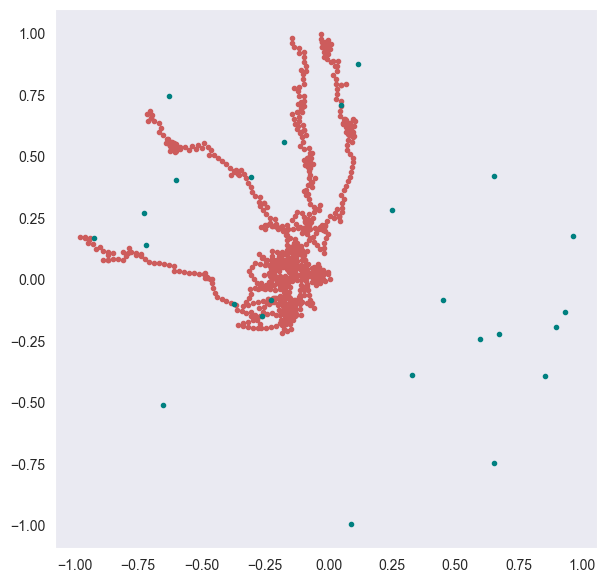

In [156]:
plt.figure(figsize=(7,7), dpi=100)
plt.plot(output[:, 0], output[:, 1], '.', color='indianred')
plt.plot(leaves.leaves[:, 0], leaves.leaves[:, 1], '.', color = 'teal')
# plt.axis('off')

In [157]:
import matplotlib.animation as animation


In [158]:
points = []
for i in clouds.keys():
    points.append(clouds[i])

MovieWriter imagemagick unavailable; using Pillow instead.


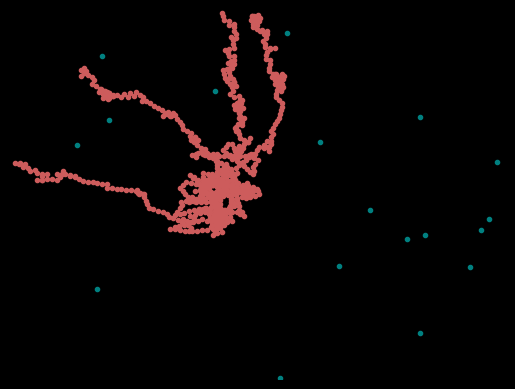

In [159]:
 
fig = plt.figure(facecolor='black')
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))
# plt.plot(leaves.leaves[:, 0], leaves.leaves[:, 1], '.', color = 'teal')
leaves, = ax.plot([], [],  '.', lw=1, color = 'teal')
line, = ax.plot([], [],  '.', lw=2, color='indianred')
plt.axis('off')
ax.set_facecolor('black')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
def init():
    # создение пустого графа.
    line.set_data([], [])
    leaves.set_data([], [])
    return line, leaves

def animate(i):
    x = output[:i][:, 0]
    y = output[:i][:, 1]
    p1 = points[i][:, 0]
    p2 = points[i][:, 1]
    line.set_data(x, y)
    leaves.set_data(p1, p2)
    return line, leaves

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(output)-1, interval=20, blit=True)
anim.save('Grow2_astro.gif', writer='imagemagick')